# Import Module

In [43]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

### Load Dataset

In [5]:
df_train = pd.read_csv('data/train.csv')
df_train = df_train.set_index('Id')

df_test = pd.read_csv('data/test.csv')
df_test = df_test.set_index('Id')

### Preprocessing

In [10]:
def preprocess_house_data(df, training=True, cat_mappings=None, feature_selector=None, selected_features=None):
    """
    Preprocessing pipeline for house price dataset.
    
    Parameters:
    -----------
    df : pandas DataFrame
        Input dataset (train.csv or test.csv)
    training : bool, default=True
        Whether this is the training dataset (with target variable)
    cat_mappings : dict, default=None
        Dictionary of mappings for categorical variables (required for test data)
    feature_selector : SelectFromModel object, default=None
        Fitted feature selector to use for feature selection
    selected_features : list, default=None
        List of feature names to select (alternative to feature_selector)
        
    Returns:
    --------
    If training=True:
        tuple: (preprocessed DataFrame, category_mappings dictionary, feature_selector, selected_features)
    If training=False:
        preprocessed DataFrame
    """
    
    # Create a copy to avoid modifying the original dataframe
    data = df.copy()
    
    # Prepare output mappings dictionary if we're in training mode
    if training:
        mappings = {}
    else:
        # If testing mode but no mappings provided, we can't properly encode
        if cat_mappings is None:
            raise ValueError("When processing test data, cat_mappings parameter is required")
        mappings = cat_mappings
    
    # Step 1: Drop variables with more than 50% missing values
    var_drop = [var for var in data.columns if data[var].isnull().sum() > 0.5*data.shape[0]]
    data = data.drop(var_drop, axis=1)
    
    # Step 2: Set 'Id' as index if it exists as a column
    if 'Id' in data.columns:
        data = data.set_index('Id')
    
    # Step 3: Split variables into categorical and numerical
    cat_vars = [var for var in data.columns if data[var].dtype == 'O']  # Object type
    cat_vars = cat_vars + ['MSSubClass']  # MSSubClass is categorical but encoded as numeric
    
    # Exclude target variable from numerical variables if it's training data
    if training:
        num_vars = [var for var in data.columns if var not in cat_vars and var != 'SalePrice']
    else:
        num_vars = [var for var in data.columns if var not in cat_vars]
    
    # Step 4: Temporal variables and year transformations
    year_vars = [var for var in num_vars if 'Yr' in var or 'Year' in var]
    
    # Handle temporal variables - convert to elapsed years
    if 'YrSold' in data.columns:
        for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
            if var in data.columns:
                data[var] = data['YrSold'] - data[var]
        
        # Drop YrSold after using it for transformations
        data.drop(['YrSold'], axis=1, inplace=True)
    
    # Step 5: Map categorical quality variables
    qual_mappings = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}
    qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                'HeatingQC', 'KitchenQual', 'FireplaceQu',
                'GarageQual', 'GarageCond']
    
    for var in qual_vars:
        if var in data.columns:
            # Fill NaN with 'Missing' first
            data[var] = data[var].fillna('Missing')
            data[var] = data[var].map(qual_mappings).fillna(0).astype(int)
    
    # Additional mappings
    if 'BsmtExposure' in data.columns:
        exposure_mappings = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4, 'Missing': 0, 'NA': 0}
        data['BsmtExposure'] = data['BsmtExposure'].fillna('Missing')
        data['BsmtExposure'] = data['BsmtExposure'].map(exposure_mappings).fillna(0).astype(int)
    
    finish_vars = ['BsmtFinType1', 'BsmtFinType2']
    finish_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
    for var in finish_vars:
        if var in data.columns:
            data[var] = data[var].fillna('Missing')
            data[var] = data[var].map(finish_mappings).fillna(0).astype(int)
    
    if 'GarageFinish' in data.columns:
        garage_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
        data['GarageFinish'] = data['GarageFinish'].fillna('Missing')
        data['GarageFinish'] = data['GarageFinish'].map(garage_mappings).fillna(0).astype(int)
    
    # Update quality variables list
    qual_vars = qual_vars + finish_vars + ['BsmtExposure','GarageFinish'] 
    
    # Step 6: Handle categorical missing values
    cat_vars_with_na = [var for var in cat_vars if var in data.columns and data[var].isnull().sum() > 0]
    
    # Variables to impute with the string "Missing"
    with_string_missing = [var for var in cat_vars_with_na if (var in data.columns) and (data[var].isnull().mean() > 0.1)]
    # Variables to impute with the most frequent category
    with_frequent_category = [var for var in cat_vars_with_na if (var in data.columns) and (data[var].isnull().mean() < 0.1)]
    
    # Fill missing values
    for var in with_string_missing:
        if var in data.columns:
            data[var] = data[var].fillna('Missing')
    
    for var in with_frequent_category:
        if var in data.columns:
            mode = data[var].mode()[0]
            data[var].fillna(mode, inplace=True)
    
    # Step 7: Handle numerical missing values
    # Update num_vars to include new columns after transformations
    num_vars = [var for var in data.columns if var not in cat_vars]
    if training:
        num_vars = [var for var in num_vars if var != 'SalePrice']
    
    vars_with_na = [var for var in num_vars if var in data.columns and data[var].isnull().sum() > 0]
    
    for var in vars_with_na:
        if var in data.columns:
            mean_val = data[var].mean()
            # Create binary indicator for missing values
            data[var + '_na'] = np.where(data[var].isnull(), 1, 0)
            # Fill missing values with mean
            data[var].fillna(mean_val, inplace=True)
    
    # Step 8: Apply log transformation to specific variables
    for var in ["LotFrontage", "1stFlrSF", "GrLivArea"]:
        if var in data.columns:
            # Replace zeros or negatives with a small value before log transform
            data[var] = np.where(data[var] <= 0, 1, data[var])
            data[var] = np.log(data[var])
    
    # Step 9: Apply Yeo-Johnson transformation to LotArea
    if 'LotArea' in data.columns:
        # Ensure no NaN or infinite values
        clean_data = data['LotArea'].replace([np.inf, -np.inf], np.nan).fillna(data['LotArea'].median())
        data['LotArea'], _ = stats.yeojohnson(clean_data)
    
    # Step 10: Binarize skewed variables
    skewed = ['BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal']
    for var in skewed:
        if var in data.columns:
            data[var] = np.where(data[var]==0, 0, 1)
    
    # Step 11: Handle remaining categorical variables (not quality variables)
    cat_others = [var for var in cat_vars if var not in qual_vars]
    
    # Handle rare labels and ordinal encoding for categorical variables
    for var in cat_others:
        if var in data.columns:
            # Group rare categories (those present in less than 1% of observations)
            if training:
                counts = data[var].value_counts() / len(data)
                frequent_ls = counts[counts > 0.01].index
                mappings[var + '_frequent'] = list(frequent_ls)
            else:
                frequent_ls = mappings[var + '_frequent']
                
            data[var] = np.where(data[var].isin(frequent_ls), data[var], 'Rare')
    
            # Order categories based on their mean SalePrice (if available)
            if training:
                ordered_labels = data.groupby([var])['SalePrice'].mean().sort_values().index
                ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}
                mappings[var + '_ordinal'] = ordinal_label
                data[var] = data[var].map(ordinal_label)
            else:
                # Use the mapping from training data
                ordinal_label = mappings[var + '_ordinal']
                # Handle potential new categories in test data
                data[var] = data[var].map(lambda x: ordinal_label.get(x, ordinal_label.get('Rare', 0)))
    
    # Step 12: Drop FireplaceQu (as done in the notebook)
    if 'FireplaceQu' in data.columns:
        data = data.drop("FireplaceQu", axis=1)
    
    # Step 13: Apply log transformation to target (only for training)
    if training and 'SalePrice' in data.columns:
        data['SalePrice'] = np.log(data['SalePrice'])
    
    # Step 14: Feature selection
    if training:
        from sklearn.preprocessing import MinMaxScaler
        from sklearn.feature_selection import SelectFromModel
        from sklearn.linear_model import Lasso
        
        X = data.drop("SalePrice", axis=1).copy()
        y = data["SalePrice"].copy()
        
        # Apply feature scaling - necessary for feature selection
        scaler = MinMaxScaler()
        X_scaled = pd.DataFrame(
            scaler.fit_transform(X),
            columns=X.columns,
            index=X.index
        )
        
        # Feature selection with Lasso
        sel_ = SelectFromModel(Lasso(alpha=0.001, random_state=42))
        sel_.fit(X_scaled, y)
        
        # Get selected feature names
        selected_feats = X_scaled.columns[sel_.get_support()].tolist()
        
        # Remove GrLivArea as in the notebook
        if "GrLivArea" in selected_feats:
            selected_feats.remove("GrLivArea")
            
        # Return only selected features and target
        if 'SalePrice' in data.columns:
            data = pd.concat([data[selected_feats], data[['SalePrice']]], axis=1)
        else:
            data = data[selected_feats]
            
        return data, mappings, sel_, selected_feats
    else:
        if selected_features is not None:
            features_to_use = [f for f in selected_features if f in data.columns]
            data = data[features_to_use]
        elif feature_selector is not None:
            # Apply feature selection mask to test data
            X_scaled = pd.DataFrame(
                MinMaxScaler().fit_transform(data),
                columns=data.columns,
                index=data.index
            )
            mask = feature_selector.get_support()
            selected_cols = X_scaled.columns[mask].tolist()
            if "GrLivArea" in selected_cols:
                selected_cols.remove("GrLivArea")
            data = data[selected_cols]
        
        return data

In [26]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Train model
    model.fit(X_train, y_train)
    
    # Predict on train and test data
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Calculate metrics for training data
    train_mse = int(mean_squared_error(np.exp(y_train), np.exp(train_pred)))
    train_rmse = int(root_mean_squared_error(np.exp(y_train), np.exp(train_pred)))
    train_r2 = r2_score(np.exp(y_train), np.exp(train_pred))

    # Calculate metrics for test data
    test_mse = int(mean_squared_error(np.exp(y_test), np.exp(test_pred)))
    test_rmse = int(root_mean_squared_error(np.exp(y_test), np.exp(test_pred)))
    test_r2 = r2_score(np.exp(y_test), np.exp(test_pred))
    
    print(f"{model_name} Performance:")
    print(f"Training MSE: {train_mse}")
    print(f"Training RMSE: {train_rmse}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Testing MSE: {test_mse}")
    print(f"Testing RMSE: {test_rmse}")
    print(f"Testing R²: {test_r2:.4f}")
    print("-" * 50)
    
    return {
        "model": model,
        "name": model_name,
        "train_mse": train_mse,
        "train_rmse": train_rmse,
        "train_r2": train_r2,
        "test_mse": test_mse,
        "test_rmse": test_rmse,
        "test_r2": test_r2
    }

In [37]:
def cross_val_evaluate(model, X, y, model_name, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Evaluasi model menggunakan cross-validation
    mse_scores = -cross_val_score(model, X, y, 
                                  scoring='neg_mean_squared_error', 
                                  cv=kf)
    rmse_scores = -cross_val_score(model, X, y, 
                                  scoring='neg_root_mean_squared_error', 
                                  cv=kf)
    r2_scores = cross_val_score(model, X, y, 
                               scoring='r2', 
                               cv=kf)
    
    # Print hasil
    print(f"{model_name} Cross-Validation Performance:")
    print(f"CV MSE: {int(np.exp(mse_scores).mean())}")
    print(f"CV RMSE: {int(np.exp(rmse_scores).mean())}")
    print(f"CV R²: {r2_scores.mean():.4f}")
    print("-" * 50)
    
    return {
        "model": model,
        "name": model_name,
        "cv_mse": int(np.exp(mse_scores).mean()),
        "cv_rmse": int(np.exp(rmse_scores).mean()),
        "cv_r2": r2_scores.mean()
    }

In [14]:
# For training data:
train_preprocessed, cat_mappings, feature_selector, selected_features = preprocess_house_data(df_train.copy(), training=True)

# For test data:
test_preprocessed = preprocess_house_data(
    df_test.copy(), 
    training=False, 
    cat_mappings=cat_mappings,
    selected_features=selected_features
)

C:\Users\Deva\AppData\Local\Temp\ipykernel_21332\2342265618.py:117: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[var].fillna(mode, inplace=True)
C:\Users\Deva\AppData\Local\Temp\ipykernel_21332\2342265618.py:133: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when

### Make and evaluation each models

In [17]:
X_train, X_test, y_train, y_test = train_test_split(train_preprocessed.drop('SalePrice', axis=1), train_preprocessed['SalePrice'], test_size=0.2, random_state=42)

In [18]:
# Define the models to evaluate
models = [
    (LinearRegression(), "Linear Regression"),
    (Ridge(alpha=0.5), "Ridge Regression"),
    (Lasso(alpha=0.001), "Lasso Regression"),
    (ElasticNet(alpha=0.001, l1_ratio=0.5), "ElasticNet"),
    (RandomForestRegressor(n_estimators=100, random_state=42), "Random Forest"),
    (GradientBoostingRegressor(n_estimators=100, random_state=42), "Gradient Boosting"),
    (XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42), "XGBoost"),
    (lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42), "LightGBM"),
    (cb.CatBoostRegressor(n_estimators=100, learning_rate=0.1, random_state=42, verbose=False), "CatBoost"),
    (SVR(kernel='rbf', C=10.0), "Support Vector Regression"),
    (KNeighborsRegressor(n_neighbors=5), "K-Nearest Neighbors")
]

In [38]:
# Evaluate each model
results = []
for model, name in models:
    result = evaluate_model(model, X_train, y_train, X_test, y_test, name)
    results.append(result)

# sort results by test RMSE and MSE
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('test_rmse')

Linear Regression Performance:
Training MSE: 762710894
Training RMSE: 27617
Training R²: 0.8721
Testing MSE: 719804589
Testing RMSE: 26829
Testing R²: 0.9062
--------------------------------------------------
Ridge Regression Performance:
Training MSE: 762173677
Training RMSE: 27607
Training R²: 0.8722
Testing MSE: 721091808
Testing RMSE: 26853
Testing R²: 0.9060
--------------------------------------------------
Lasso Regression Performance:
Training MSE: 775897260
Training RMSE: 27854
Training R²: 0.8699
Testing MSE: 732687097
Testing RMSE: 27068
Testing R²: 0.9045
--------------------------------------------------
ElasticNet Performance:
Training MSE: 767934616
Training RMSE: 27711
Training R²: 0.8713
Testing MSE: 727051766
Testing RMSE: 26963
Testing R²: 0.9052
--------------------------------------------------
Random Forest Performance:
Training MSE: 136720227
Training RMSE: 11692
Training R²: 0.9771
Testing MSE: 755995611
Testing RMSE: 27495
Testing R²: 0.9014
-------------------

### Cross-validation for more robust evaluation

In [39]:
# evaluate models using cross-validation
cv_results = []
for model, name in models:
    cv_result = cross_val_evaluate(model, X_train, y_train, name)
    cv_results.append(cv_result)

# sort results by CV RMSE
cv_results_df = pd.DataFrame(cv_results)
cv_results_df = cv_results_df.sort_values('cv_rmse')

Linear Regression Cross-Validation Performance:
CV MSE: 1
CV RMSE: 1
CV R²: 0.8928
--------------------------------------------------
Ridge Regression Cross-Validation Performance:
CV MSE: 1
CV RMSE: 1
CV R²: 0.8928
--------------------------------------------------
Lasso Regression Cross-Validation Performance:
CV MSE: 1
CV RMSE: 1
CV R²: 0.8924
--------------------------------------------------
ElasticNet Cross-Validation Performance:
CV MSE: 1
CV RMSE: 1
CV R²: 0.8928
--------------------------------------------------
Random Forest Cross-Validation Performance:
CV MSE: 1
CV RMSE: 1
CV R²: 0.8537
--------------------------------------------------
Gradient Boosting Cross-Validation Performance:
CV MSE: 1
CV RMSE: 1
CV R²: 0.8856
--------------------------------------------------
XGBoost Cross-Validation Performance:
CV MSE: 1
CV RMSE: 1
CV R²: 0.8770
--------------------------------------------------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was

### Visualization perfomance each models

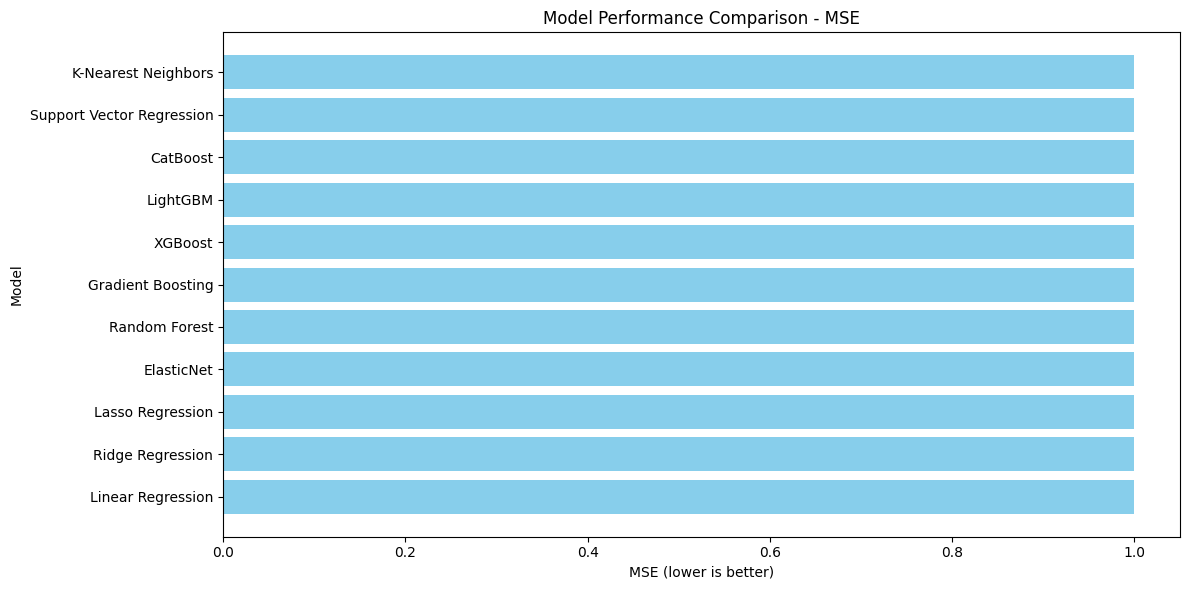

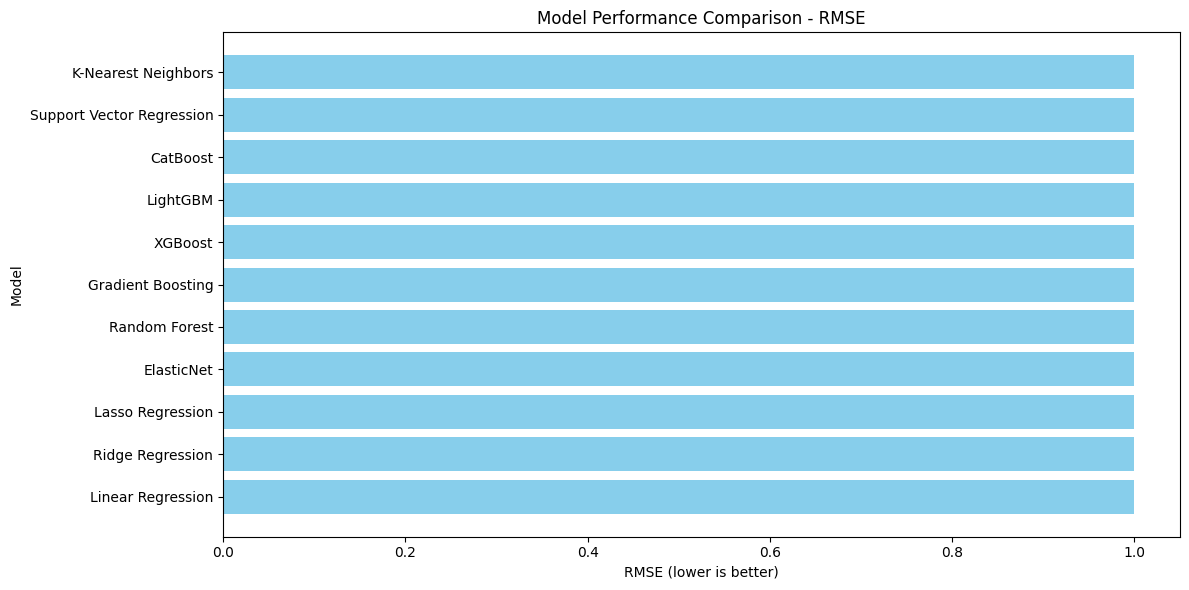

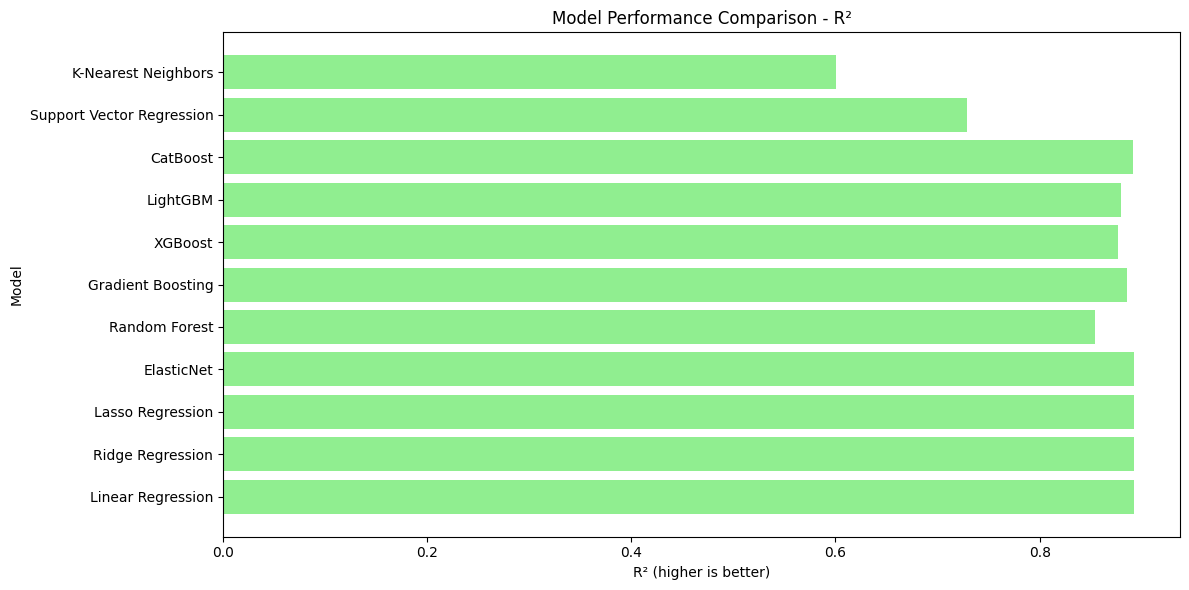

In [ ]:
# Plot the comparation of MSE from each models
plt.figure(figsize=(12, 6))
plt.barh(cv_results_df['name'], cv_results_df['cv_mse'], color='skyblue')
plt.xlabel('MSE (lower is better)')
plt.ylabel('Model')
plt.title('Model Performance Comparison - MSE')
plt.tight_layout()
plt.show()

# Plot the comparation of RMSE from each models
plt.figure(figsize=(12, 6))
plt.barh(cv_results_df['name'], cv_results_df['cv_rmse'], color='skyblue')
plt.xlabel('RMSE (lower is better)')
plt.ylabel('Model')
plt.title('Model Performance Comparison - RMSE')
plt.tight_layout()
plt.show()

# plot the comparation of R² from each models
plt.figure(figsize=(12, 6))
plt.barh(cv_results_df['name'], cv_results_df['cv_r2'], color='lightgreen')
plt.xlabel('R² (higher is better)')
plt.ylabel('Model')
plt.title('Model Performance Comparison - R²')
plt.tight_layout()
plt.show()

### Hyperparameter tuning for best models

------------------------------------------------------------------------

In [47]:
# Define parameter grids for each model
param_grid_linear = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

param_grid_ridge = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0, 50.0, 100.0],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

param_grid_lasso = {
    'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0],
    'max_iter': [1000, 2000, 3000],
    'selection': ['cyclic', 'random']
}

param_grid_elasticnet = {
    'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'max_iter': [1000, 2000],
    'selection': ['cyclic', 'random']
}

# Dictionary of models and their parameter grids
models_to_tune = {
    'Linear Regression': (LinearRegression(), param_grid_linear),
    'Ridge': (Ridge(random_state=42), param_grid_ridge),
    'Lasso': (Lasso(random_state=42), param_grid_lasso),
    'ElasticNet': (ElasticNet(random_state=42), param_grid_elasticnet)
}

# Store the best models after tuning
best_models = {}

# Perform grid search for each model
for model_name, (model, param_grid) in models_to_tune.items():
    print(f"\nTuning hyperparameters for {model_name}...")
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    # Get best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = -grid_search.best_score_  # Convert back to positive RMSE
    
    print(f"Best parameters for {model_name}: {best_params}")
    print(f"Best CV RMSE: {best_score:.4f}")
    
    # Store the best model
    best_models[model_name] = best_model
    
    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    test_rmse = root_mean_squared_error(np.exp(y_test), np.exp(y_pred))
    test_r2 = r2_score(np.exp(y_test), np.exp(y_pred))
    
    print(f"Test RMSE: {int(test_rmse)}")
    print(f"Test R²: {test_r2:.4f}")
    print("-" * 50)


Tuning hyperparameters for Linear Regression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for Linear Regression: {'fit_intercept': True, 'positive': True}
Best CV RMSE: 0.1294
Test RMSE: 26683
Test R²: 0.9072
--------------------------------------------------

Tuning hyperparameters for Ridge...
Fitting 5 folds for each of 63 candidates, totalling 315 fits
Best parameters for Ridge: {'alpha': 1.0, 'solver': 'auto'}
Best CV RMSE: 0.1297
Test RMSE: 26877
Test R²: 0.9058
--------------------------------------------------

Tuning hyperparameters for Lasso...
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best parameters for Lasso: {'alpha': 0.0001, 'max_iter': 1000, 'selection': 'random'}
Best CV RMSE: 0.1298
Test RMSE: 26847
Test R²: 0.9060
--------------------------------------------------

Tuning hyperparameters for ElasticNet...
Fitting 5 folds for each of 140 candidates, totalling 700 fits
Best parameters for ElasticNet: {'alpha': 0.00

In [48]:
# Create ensemble from tuned models
tuned_models = list(best_models.values())

# Function to make predictions using the ensemble
def ensemble_predict(models, X):
    predictions = np.column_stack([model.predict(X) for model in models])
    return np.mean(predictions, axis=1)

# Evaluate the ensemble on test data
ensemble_preds = ensemble_predict(tuned_models, X_test)
ensemble_mse = int(mean_squared_error(np.exp(y_test), np.exp(ensemble_preds)))
ensemble_rmse = int(root_mean_squared_error(np.exp(y_test), np.exp(ensemble_preds)))
ensemble_r2 = r2_score(np.exp(y_test), np.exp(ensemble_preds))

print("\nEnsemble Model Performance:")
print(f"MSE: {ensemble_mse}")
print(f"RMSE: {ensemble_rmse}")
print(f"R²: {ensemble_r2:.4f}")


Ensemble Model Performance:
MSE: 719374712
RMSE: 26821
R²: 0.9062


In [49]:
# Define complete dataset (that was previously split into train/test)
X_full = train_preprocessed.drop('SalePrice', axis=1)
y_full = train_preprocessed['SalePrice']

# After tuning and selecting the best models, train them on the full dataset
for model in tuned_models:
    model.fit(X_full, y_full)

# Then make ensemble predictions on the test data
final_ensemble_preds = ensemble_predict(tuned_models, test_preprocessed)
final_predictions = np.exp(final_ensemble_preds)  # Convert back from log scale

# Save predictions to submission file
submission = pd.DataFrame({
    'Id': test_preprocessed.index,
    'SalePrice': final_predictions
})
submission.to_csv('submission.csv', index=False)